# Ottawa Tabular Collision Data 2015-2017 #4# Create Machine Learning Model

In [1]:
import sys
print(sys.executable)
import os
import pandas as pd
import numpy as np

import xgboost
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, Binarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve  
from sklearn.metrics import average_precision_score, precision_recall_curve, confusion_matrix, classification_report
import matplotlib.pyplot as plt

import math 
import datetime
import time

print("Changing Directory")

basedir = 'C:\\Users\\Enrique\\PycharmProjects\\TestGeopandas'
os.chdir(basedir)

data_type = '2to1 - NEW'
data_file = basedir + '\\Tabular Data 2015-2017 datafiles\\Ottawa Tabular Collision Data 2015-2017 FINAL DATA with Sampling and Events '+data_type+'.csv'


C:\Users\Enrique\Anaconda3\envs\mlenv\python.exe
Changing Directory


# 1. Load the Collision Dataset with Sampling and Events

In [2]:
df = pd.read_csv(data_file, dtype = str, na_values = "", keep_default_na = False)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130482 entries, 0 to 130481
Data columns (total 59 columns):
ACCIDENT_DATE                 130482 non-null object
ACCIDENT_DATE_TIME            130482 non-null object
ACCIDENT_LOCATION             130466 non-null object
ACCIDENT_TIME                 130482 non-null object
CLASSIFICATION_OF_ACCIDENT    130482 non-null object
ENVIRONMENT_CONDITION         130480 non-null object
IMPACT_TYPE                   43494 non-null object
LATITUDE                      130482 non-null object
LIGHT                         130477 non-null object
LOCATION                      130482 non-null object
LOCATION_A                    130454 non-null object
LOCATION_B                    130454 non-null object
LONGITUDE                     130482 non-null object
ONS_ID                        130482 non-null object
ONS_NAME                      130482 non-null object
ROAD_DIRECTION                130482 non-null object
ROAD_LEN                      130482 non-n

,ACCIDENT_DATE,ACCIDENT_DATE_TIME,ACCIDENT_LOCATION,ACCIDENT_TIME,CLASSIFICATION_OF_ACCIDENT,ENVIRONMENT_CONDITION,IMPACT_TYPE,LATITUDE,LIGHT,LOCATION,...,COLLISION,ROAD_SINUOSITY_LOG,ROAD_LEN_LOG,SOLAR_AZIMUTH_LOG,SOLAR_ELEVATION_LOG,NUMBER_OF_COLLISIONS,STREET1,STREET2,STREET3,ACCIDENT_DATE_weekm
0,2015-01-01,2015-01-01 0:30,03 - At intersection,12:30:00 AM,03 - P.D. only,01 - Clear,02 - Angle,45.41934473,07 - Dark,LAURIER AVE @ O'CONNOR ST,...,1,0,0,3.191710157,4.190260619,42,LAURIER AVE,@ O'CONNOR ST,NaN,1
1,2015-01-01,2015-01-01 13:15,03 - At intersection,1:15:00 PM,03 - P.D. only,03 - Snow,03 - Rear end,45.42876352,01 - Daylight,KING EDWARD AVE @ RIDEAU ST,...,1,0,0,5.303553633,2.936512914,132,KING EDWARD AVE,@ RIDEAU ST,NaN,1
2,2015-01-01,2015-01-01 13:54,03 - At intersection,1:54:00 PM,02 - Non-fatal injury,01 - Clear,05 - Turning movement,45.27524017,01 - Daylight,BEATRICE DR @ STRANDHERD DR,...,1,0,0,5.346726506,2.776331709,57,BEATRICE DR,@ STRANDHERD DR,NaN,1
3,2015-01-01,2015-01-01 15:15,03 - At intersection,3:15:00 PM,02 - Non-fatal injury,01 - Clear,02 - Angle,45.39662951,01 - Daylight,QUEEN ELIZABETH DRWY @ QUEEN ELIZABETH PL,...,1,0,0,5.423627558,1.972691172,14,QUEEN ELIZABETH DRWY,@ QUEEN ELIZABETH PL,NaN,1
4,2015-01-01,2015-01-01 17:30,02 - Intersection related,5:30:00 PM,03 - P.D. only,03 - Snow,03 - Rear end,45.48077499,05 - Dusk,OLD TENTH LINE RD @ TENTH LINE RD,...,1,0,0,5.523698413,2.580974119,54,OLD TENTH LINE RD,@ TENTH LINE RD,NaN,1


# 2. Clean the Dataset

In [3]:
df = df.drop(columns=['ACCIDENT_DATE','ACCIDENT_DATE_TIME','ACCIDENT_TIME','ACCIDENT_DATE_year',
                      'CLASSIFICATION_OF_ACCIDENT','IMPACT_TYPE', 
                      'XCOORD','YCOORD','LATITUDE','LONGITUDE', 
                      'ROAD_ROW_NUMBER','ROW_ID', 
                      'SOLAR_AZIMUTH_LOG','SOLAR_ELEVATION_LOG', 
                      'ONS_ID', 
                       #'LOCATION_A', 'LOCATION_B',
                       #'STREET1','STREET2',
                      'ENVIRONMENT_CONDITION', 'ROAD_SURFACE_CONDITION','LIGHT',
                      'STREET3'                    
                      ],
             errors='ignore')

df['COLLISION'] = df['COLLISION'].astype(np.int)

# Drop NA Values
df = df.dropna(how='any',axis=0)

print("Number of Samples="+str(len(df)))
non_collision_len = len(df[df['COLLISION'] == 0])
collision_len = len(df[df['COLLISION'] == 1])
                    
print("Number of Non-collision Samples="+str(non_collision_len))
print("Number of Collision Samples="+str(collision_len))
print("Non-collision/collision ratio="+str(non_collision_len/collision_len)+'\n')

df.info()
df.head()

Number of Samples=129332
Number of Non-collision Samples=86222
Number of Collision Samples=43110
Non-collision/collision ratio=2.000046392948272

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129332 entries, 0 to 130481
Data columns (total 40 columns):
ACCIDENT_LOCATION            129332 non-null object
LOCATION                     129332 non-null object
LOCATION_A                   129332 non-null object
LOCATION_B                   129332 non-null object
ONS_NAME                     129332 non-null object
ROAD_DIRECTION               129332 non-null object
ROAD_LEN                     129332 non-null object
ROAD_NAME                    129332 non-null object
ROAD_SEGMENT                 129332 non-null object
ROAD_SINUOSITY               129332 non-null object
ROAD_SUBCLASS                129332 non-null object
ROAD_SUBTYPE                 129332 non-null object
TILE_ID                      129332 non-null object
TRAFFIC_CONTROL              129332 non-null object
ACCIDENT_DATE_d

,ACCIDENT_LOCATION,LOCATION,LOCATION_A,LOCATION_B,ONS_NAME,ROAD_DIRECTION,ROAD_LEN,ROAD_NAME,ROAD_SEGMENT,ROAD_SINUOSITY,...,CARLETON_CALENDAR_WINTER,CARLETON_CALENDAR_SUMMER,CARLETON_CALENDAR_FALL,COLLISION,ROAD_SINUOSITY_LOG,ROAD_LEN_LOG,NUMBER_OF_COLLISIONS,STREET1,STREET2,ACCIDENT_DATE_weekm
0,03 - At intersection,LAURIER AVE @ O'CONNOR ST,LAURIER AVE,@ O'CONNOR ST,Centretown,NA,1,O'CONNOR ST @ LAURIER AVE W,__3Z09QI @ __3Z09QQ,1,...,0,0,0,1,0,0,42,LAURIER AVE,@ O'CONNOR ST,1
1,03 - At intersection,KING EDWARD AVE @ RIDEAU ST,KING EDWARD AVE,@ RIDEAU ST,Lowertown,NA,1,KING EDWARD AVE @ RIDEAU ST,__3Z09HJ @ __3Z09HI,1,...,0,0,0,1,0,0,132,KING EDWARD AVE,@ RIDEAU ST,1
2,03 - At intersection,BEATRICE DR @ STRANDHERD DR,BEATRICE DR,@ STRANDHERD DR,Stonebridge - Halfmoon Bay - Heart's Desire,NA,1,STRANDHERD DR @ BEATRICE DR,__3ZAJDR @ __4FP8LZ,1,...,0,0,0,1,0,0,57,BEATRICE DR,@ STRANDHERD DR,1
3,03 - At intersection,QUEEN ELIZABETH DRWY @ QUEEN ELIZABETH PL,QUEEN ELIZABETH DRWY,@ QUEEN ELIZABETH PL,Glebe - Dows Lake,NA,1,QUEEN ELIZABETH DRWY @ BANK ST @ COLONEL BY DR...,__3Z08JE @ __3Z089I @ __3Z05SW @ __3Z0EVZ,1,...,0,0,0,1,0,0,14,QUEEN ELIZABETH DRWY,@ QUEEN ELIZABETH PL,1
4,02 - Intersection related,OLD TENTH LINE RD @ TENTH LINE RD,OLD TENTH LINE RD,@ TENTH LINE RD,Queenswood Heights,NA,1,OLD TENTH LINE RD @ TENTH LINE RD,__3Z06BL @ __3Z060T,1,...,0,0,0,1,0,0,54,OLD TENTH LINE RD,@ TENTH LINE RD,1


# 3. Select and Encode Features 

## 3.1 Continuos Features

In [4]:
# Continuously valued features
float_feature_names = [
    'ROAD_LEN',
    'ROAD_SINUOSITY',
    #'XCOORD',
    #'YCOORD',
    'SOLAR_AZIMUTH',
    'SOLAR_ELEVATION',
    'ROAD_SINUOSITY_LOG',
    'ROAD_LEN_LOG',
    'NUMBER_OF_COLLISIONS'
]

df[float_feature_names].info()
df[float_feature_names].head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129332 entries, 0 to 130481
Data columns (total 7 columns):
ROAD_LEN                129332 non-null object
ROAD_SINUOSITY          129332 non-null object
SOLAR_AZIMUTH           129332 non-null object
SOLAR_ELEVATION         129332 non-null object
ROAD_SINUOSITY_LOG      129332 non-null object
ROAD_LEN_LOG            129332 non-null object
NUMBER_OF_COLLISIONS    129332 non-null object
dtypes: object(7)
memory usage: 7.9+ MB


,ROAD_LEN,ROAD_SINUOSITY,SOLAR_AZIMUTH,SOLAR_ELEVATION,ROAD_SINUOSITY_LOG,ROAD_LEN_LOG,NUMBER_OF_COLLISIONS
0,1,1,24.33,-66.04,0,0,42
1,1,1,201.05,18.85,0,0,132
2,1,1,209.92,16.06,0,0,57
3,1,1,226.7,7.19,0,0,14
4,1,1,250.56,-13.21,0,0,54


In [5]:
float_features = df.xs(float_feature_names,axis=1).values

# Use scikit-learn's StandardScaler
scaler = StandardScaler()

float_scaled = scaler.fit_transform(float_features)
df[float_feature_names] = float_scaled
    
df[float_feature_names].info()
df[float_feature_names].head()

C:\Users\Enrique\Anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Enrique\Anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 129332 entries, 0 to 130481
Data columns (total 7 columns):
ROAD_LEN                129332 non-null float64
ROAD_SINUOSITY          129332 non-null float64
SOLAR_AZIMUTH           129332 non-null float64
SOLAR_ELEVATION         129332 non-null float64
ROAD_SINUOSITY_LOG      129332 non-null float64
ROAD_LEN_LOG            129332 non-null float64
NUMBER_OF_COLLISIONS    129332 non-null float64
dtypes: float64(7)
memory usage: 7.9 MB


,ROAD_LEN,ROAD_SINUOSITY,SOLAR_AZIMUTH,SOLAR_ELEVATION,ROAD_SINUOSITY_LOG,ROAD_LEN_LOG,NUMBER_OF_COLLISIONS
0,-0.386392,-0.082315,-2.286122,-2.532979,-0.153967,-0.909818,-0.306694
1,-0.386392,-0.082315,-0.071188,0.277954,-0.153967,-0.909818,0.838890
2,-0.386392,-0.082315,0.039985,0.185569,-0.153967,-0.909818,-0.115763
3,-0.386392,-0.082315,0.250298,-0.108140,-0.153967,-0.909818,-0.663098
4,-0.386392,-0.082315,0.549349,-0.783638,-0.153967,-0.909818,-0.153949


## 3.2 Categorical Features

In [6]:
# Categorical valued features
categorical_feature_names = [
    'ACCIDENT_LOCATION',
    #'ENVIRONMENT_CONDITION',
    #'ROAD_SURFACE_CONDITION',
    #'LIGHT',
    'LOCATION',
    'LOCATION_A',
    'LOCATION_B',
    'STREET1',
    'STREET2',
    #'STREET3',
    'ROAD_DIRECTION',
    'ROAD_NAME',
    'ROAD_SEGMENT',
    'ONS_NAME',
    'TRAFFIC_CONTROL',
    'ROAD_SUBCLASS',
    'ROAD_SUBTYPE',
    'TILE_ID'
]

df[categorical_feature_names].info()
df[categorical_feature_names].head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129332 entries, 0 to 130481
Data columns (total 14 columns):
ACCIDENT_LOCATION    129332 non-null object
LOCATION             129332 non-null object
LOCATION_A           129332 non-null object
LOCATION_B           129332 non-null object
STREET1              129332 non-null object
STREET2              129332 non-null object
ROAD_DIRECTION       129332 non-null object
ROAD_NAME            129332 non-null object
ROAD_SEGMENT         129332 non-null object
ONS_NAME             129332 non-null object
TRAFFIC_CONTROL      129332 non-null object
ROAD_SUBCLASS        129332 non-null object
ROAD_SUBTYPE         129332 non-null object
TILE_ID              129332 non-null object
dtypes: object(14)
memory usage: 14.8+ MB


,ACCIDENT_LOCATION,LOCATION,LOCATION_A,LOCATION_B,STREET1,STREET2,ROAD_DIRECTION,ROAD_NAME,ROAD_SEGMENT,ONS_NAME,TRAFFIC_CONTROL,ROAD_SUBCLASS,ROAD_SUBTYPE,TILE_ID
0,03 - At intersection,LAURIER AVE @ O'CONNOR ST,LAURIER AVE,@ O'CONNOR ST,LAURIER AVE,@ O'CONNOR ST,NA,O'CONNOR ST @ LAURIER AVE W,__3Z09QI @ __3Z09QQ,Centretown,01 - Traffic signal,INTER-ARTERIAL,2,1804
1,03 - At intersection,KING EDWARD AVE @ RIDEAU ST,KING EDWARD AVE,@ RIDEAU ST,KING EDWARD AVE,@ RIDEAU ST,NA,KING EDWARD AVE @ RIDEAU ST,__3Z09HJ @ __3Z09HI,Lowertown,01 - Traffic signal,INTER-ARTERIAL,2,1853
2,03 - At intersection,BEATRICE DR @ STRANDHERD DR,BEATRICE DR,@ STRANDHERD DR,BEATRICE DR,@ STRANDHERD DR,NA,STRANDHERD DR @ BEATRICE DR,__3ZAJDR @ __4FP8LZ,Stonebridge - Halfmoon Bay - Heart's Desire,01 - Traffic signal,INTER-ARTERIAL,2,1696
3,03 - At intersection,QUEEN ELIZABETH DRWY @ QUEEN ELIZABETH PL,QUEEN ELIZABETH DRWY,@ QUEEN ELIZABETH PL,QUEEN ELIZABETH DRWY,@ QUEEN ELIZABETH PL,NA,QUEEN ELIZABETH DRWY @ BANK ST @ COLONEL BY DR...,__3Z08JE @ __3Z089I @ __3Z05SW @ __3Z0EVZ,Glebe - Dows Lake,02 - Stop sign,INTER-LOCAL,8,1849
4,02 - Intersection related,OLD TENTH LINE RD @ TENTH LINE RD,OLD TENTH LINE RD,@ TENTH LINE RD,OLD TENTH LINE RD,@ TENTH LINE RD,NA,OLD TENTH LINE RD @ TENTH LINE RD,__3Z06BL @ __3Z060T,Queenswood Heights,01 - Traffic signal,INTER-ARTERIAL,2,2524


In [7]:
# Use scikit-learn's LabelEncoder
le = LabelEncoder()

df[categorical_feature_names] = df[categorical_feature_names].apply(lambda col: le.fit_transform(col))

df[categorical_feature_names].info()
df[categorical_feature_names].head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129332 entries, 0 to 130481
Data columns (total 14 columns):
ACCIDENT_LOCATION    129332 non-null int32
LOCATION             129332 non-null int32
LOCATION_A           129332 non-null int32
LOCATION_B           129332 non-null int32
STREET1              129332 non-null int32
STREET2              129332 non-null int32
ROAD_DIRECTION       129332 non-null int32
ROAD_NAME            129332 non-null int32
ROAD_SEGMENT         129332 non-null int32
ONS_NAME             129332 non-null int32
TRAFFIC_CONTROL      129332 non-null int32
ROAD_SUBCLASS        129332 non-null int32
ROAD_SUBTYPE         129332 non-null int32
TILE_ID              129332 non-null int32
dtypes: int32(14)
memory usage: 7.9 MB


,ACCIDENT_LOCATION,LOCATION,LOCATION_A,LOCATION_B,STREET1,STREET2,ROAD_DIRECTION,ROAD_NAME,ROAD_SEGMENT,ONS_NAME,TRAFFIC_CONTROL,ROAD_SUBCLASS,ROAD_SUBTYPE,TILE_ID
0,2,5996,1985,1142,1985,1142,1,3936,4432,23,0,6,1,434
1,2,5758,1895,1365,1895,1365,1,2987,4090,62,0,6,1,467
2,2,980,273,1630,273,1630,1,5252,8476,95,0,6,1,350
3,2,7989,2661,1305,2661,1305,1,4375,2883,41,1,12,6,463
4,1,7406,2451,1688,2451,1688,1,4018,1370,83,0,6,1,914


## 3.3 Binary Features

In [8]:
# Binay valued features
binary_feature_names = [
    'COLLISION',
    'OTTAWA_FURY_SOCCER',
    'OTTAWA_SENATORS_HOCKEY',
    'OTTAWA_67S_HOCKEY',
    'OTTAWA_REDBLACKS_FOOTBALL',
    'OTTAWA_RAVENS_FOOTBALL',
    'OTTAWA_GEEGEES_FOOTBALL',
    'OTTAWA_STATUTORY_HOLIDAYS',     
    'OTTAWA_CHAMPIONS_BBC',
    'CARLETON_CALENDAR_WINTER',
    'CARLETON_CALENDAR_SUMMER',
    'CARLETON_CALENDAR_FALL'
]

df[binary_feature_names].info()
df[binary_feature_names].head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129332 entries, 0 to 130481
Data columns (total 12 columns):
COLLISION                    129332 non-null int32
OTTAWA_FURY_SOCCER           129332 non-null object
OTTAWA_SENATORS_HOCKEY       129332 non-null object
OTTAWA_67S_HOCKEY            129332 non-null object
OTTAWA_REDBLACKS_FOOTBALL    129332 non-null object
OTTAWA_RAVENS_FOOTBALL       129332 non-null object
OTTAWA_GEEGEES_FOOTBALL      129332 non-null object
OTTAWA_STATUTORY_HOLIDAYS    129332 non-null object
OTTAWA_CHAMPIONS_BBC         129332 non-null object
CARLETON_CALENDAR_WINTER     129332 non-null object
CARLETON_CALENDAR_SUMMER     129332 non-null object
CARLETON_CALENDAR_FALL       129332 non-null object
dtypes: int32(1), object(11)
memory usage: 12.3+ MB


,COLLISION,OTTAWA_FURY_SOCCER,OTTAWA_SENATORS_HOCKEY,OTTAWA_67S_HOCKEY,OTTAWA_REDBLACKS_FOOTBALL,OTTAWA_RAVENS_FOOTBALL,OTTAWA_GEEGEES_FOOTBALL,OTTAWA_STATUTORY_HOLIDAYS,OTTAWA_CHAMPIONS_BBC,CARLETON_CALENDAR_WINTER,CARLETON_CALENDAR_SUMMER,CARLETON_CALENDAR_FALL
0,1,0,0,0,0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,0,1,0,0,0,0
2,1,0,0,0,0,0,0,1,0,0,0,0
3,1,0,0,0,0,0,0,1,0,0,0,0
4,1,0,0,0,0,0,0,1,0,0,0,0


In [9]:
binary_features = df.xs(binary_feature_names,axis=1).values

# Use scikit-learn's Binarizer
binarizer = Binarizer()

binary_transformed = binarizer.fit_transform(binary_features)
df[binary_feature_names] = binary_transformed

df[binary_feature_names].info()
df[binary_feature_names].head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129332 entries, 0 to 130481
Data columns (total 12 columns):
COLLISION                    129332 non-null float64
OTTAWA_FURY_SOCCER           129332 non-null float64
OTTAWA_SENATORS_HOCKEY       129332 non-null float64
OTTAWA_67S_HOCKEY            129332 non-null float64
OTTAWA_REDBLACKS_FOOTBALL    129332 non-null float64
OTTAWA_RAVENS_FOOTBALL       129332 non-null float64
OTTAWA_GEEGEES_FOOTBALL      129332 non-null float64
OTTAWA_STATUTORY_HOLIDAYS    129332 non-null float64
OTTAWA_CHAMPIONS_BBC         129332 non-null float64
CARLETON_CALENDAR_WINTER     129332 non-null float64
CARLETON_CALENDAR_SUMMER     129332 non-null float64
CARLETON_CALENDAR_FALL       129332 non-null float64
dtypes: float64(12)
memory usage: 12.8 MB


,COLLISION,OTTAWA_FURY_SOCCER,OTTAWA_SENATORS_HOCKEY,OTTAWA_67S_HOCKEY,OTTAWA_REDBLACKS_FOOTBALL,OTTAWA_RAVENS_FOOTBALL,OTTAWA_GEEGEES_FOOTBALL,OTTAWA_STATUTORY_HOLIDAYS,OTTAWA_CHAMPIONS_BBC,CARLETON_CALENDAR_WINTER,CARLETON_CALENDAR_SUMMER,CARLETON_CALENDAR_FALL
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


# Hour / Time Features (NOT APPLIED)

In [10]:
# Hour/Time valued features
hour_time_feature_names = [
 'ACCIDENT_DATE_daym',
 'ACCIDENT_DATE_dayw', 
 #'ACCIDENT_DATE_dayy',
 #'ACCIDENT_DATE_year',
 #'ONS_NAME',
 #'ACCIDENT_DATE_month', 
 #'ACCIDENT_DATE_weeky',
 #'ACCIDENT_DATE_weekm',   
 #'ACCIDENT_DATE_hour',
 # 'ROAD_DIRECTION',
   #'ROAD_NAME',
    #'ROAD_SEGMENT',
    #'ONS_NAME',
  #  'TRAFFIC_CONTROL',
  #  'ROAD_SUBCLASS',
  #  'ROAD_SUBTYPE'
    #'TILE_ID'
 ]

df[hour_time_feature_names].info()
df[hour_time_feature_names].head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129332 entries, 0 to 130481
Data columns (total 2 columns):
ACCIDENT_DATE_daym    129332 non-null object
ACCIDENT_DATE_dayw    129332 non-null object
dtypes: object(2)
memory usage: 3.0+ MB


,ACCIDENT_DATE_daym,ACCIDENT_DATE_dayw
0,1,3
1,1,3
2,1,3
3,1,3
4,1,3


In [11]:
#df = pd.get_dummies(df,columns=hour_time_feature_names)
df.info()
df.head()
print(df.columns.tolist())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129332 entries, 0 to 130481
Data columns (total 40 columns):
ACCIDENT_LOCATION            129332 non-null int32
LOCATION                     129332 non-null int32
LOCATION_A                   129332 non-null int32
LOCATION_B                   129332 non-null int32
ONS_NAME                     129332 non-null int32
ROAD_DIRECTION               129332 non-null int32
ROAD_LEN                     129332 non-null float64
ROAD_NAME                    129332 non-null int32
ROAD_SEGMENT                 129332 non-null int32
ROAD_SINUOSITY               129332 non-null float64
ROAD_SUBCLASS                129332 non-null int32
ROAD_SUBTYPE                 129332 non-null int32
TILE_ID                      129332 non-null int32
TRAFFIC_CONTROL              129332 non-null int32
ACCIDENT_DATE_daym           129332 non-null object
ACCIDENT_DATE_dayw           129332 non-null object
ACCIDENT_DATE_dayy           129332 non-null object
ACCIDENT_DATE_m

# 4. Creation of Dataset

In [12]:
Y_df = df['COLLISION']
X_df = df.drop(columns=['COLLISION'])

Y = Y_df.values
X = X_df.values
feature_names = X_df.columns.tolist()

print(Y)
print("\nNumber of features:" + str(len(feature_names)) + "\n")
print(feature_names)

[1. 1. 1. ... 0. 0. 0.]

Number of features:39

['ACCIDENT_LOCATION', 'LOCATION', 'LOCATION_A', 'LOCATION_B', 'ONS_NAME', 'ROAD_DIRECTION', 'ROAD_LEN', 'ROAD_NAME', 'ROAD_SEGMENT', 'ROAD_SINUOSITY', 'ROAD_SUBCLASS', 'ROAD_SUBTYPE', 'TILE_ID', 'TRAFFIC_CONTROL', 'ACCIDENT_DATE_daym', 'ACCIDENT_DATE_dayw', 'ACCIDENT_DATE_dayy', 'ACCIDENT_DATE_month', 'ACCIDENT_DATE_weeky', 'ACCIDENT_DATE_hour', 'OTTAWA_FURY_SOCCER', 'OTTAWA_SENATORS_HOCKEY', 'OTTAWA_67S_HOCKEY', 'OTTAWA_REDBLACKS_FOOTBALL', 'OTTAWA_RAVENS_FOOTBALL', 'OTTAWA_GEEGEES_FOOTBALL', 'OTTAWA_STATUTORY_HOLIDAYS', 'OTTAWA_CHAMPIONS_BBC', 'SOLAR_AZIMUTH', 'SOLAR_ELEVATION', 'CARLETON_CALENDAR_WINTER', 'CARLETON_CALENDAR_SUMMER', 'CARLETON_CALENDAR_FALL', 'ROAD_SINUOSITY_LOG', 'ROAD_LEN_LOG', 'NUMBER_OF_COLLISIONS', 'STREET1', 'STREET2', 'ACCIDENT_DATE_weekm']


# 5. Create Testing and Test Data and define Model Variables and Parameters (Gradient Boosting Trees)

In [13]:
feature_sel = range(len(feature_names))
Xs = X[:,feature_sel]
X_train, X_test, y_train, y_test = train_test_split(Xs, Y, test_size=0.3, random_state = 2019)
fnames = np.array(feature_names)[feature_sel]

X_train = xgboost.DMatrix(X_train,label=y_train,feature_names=fnames)
X_test =  xgboost.DMatrix(X_test,label=y_test,feature_names=fnames)

#params = {
#    'n_estimators': 200,
#    'max_depth':10,
#    'min_child_weight': 1.0,
#    'reg_lambda': 1.0,
#    'reg_alpha':0.0,
#    'objective':'binary:logistic',
#    'seed': 2019,
#    'silent': 1
#}

#params = {
#    'max_depth':6,
#    'min_child_weight': 5.0,
#    'reg_lambda': 1.0,
#    'reg_alpha':0.0,
#    'scale_pos_weight':1.0,
#    'eval_metric':'auc',
#    'objective':'binary:logistic',
#    'subsample':0.8,    
#    'eta':0.3,
#    'seed': 2019,
#    'silent': 1
#}

params = {
    'max_depth':6,
    'min_child_weight': 5.0,
    'reg_lambda': 1.0,
    'reg_alpha':0.0,
    'scale_pos_weight':1.0,
    'eval_metric':'auc',
    'objective':'binary:logistic',
    #'subsample':0.9,
    'subsample': 0.7,
    'eta':0.3,
    'seed': 2019,
    'silent': 1
}

early_stopping_rounds = 50
num_boost_round = 999

# 6. Train the Model

In [14]:
booster = xgboost.train(params,X_train, 
                        num_boost_round = num_boost_round, 
                        evals=[(X_test, "Test")], 
                        early_stopping_rounds = early_stopping_rounds,
                        verbose_eval=1)

[0]	Test-auc:0.685615
Will train until Test-auc hasn't improved in 50 rounds.
[1]	Test-auc:0.677442
[2]	Test-auc:0.683868
[3]	Test-auc:0.688992
[4]	Test-auc:0.701758
[5]	Test-auc:0.714555
[6]	Test-auc:0.746946
[7]	Test-auc:0.745985
[8]	Test-auc:0.74934
[9]	Test-auc:0.768503
[10]	Test-auc:0.772198
[11]	Test-auc:0.776666
[12]	Test-auc:0.783715
[13]	Test-auc:0.785394
[14]	Test-auc:0.788658
[15]	Test-auc:0.790326
[16]	Test-auc:0.796695
[17]	Test-auc:0.796412
[18]	Test-auc:0.79861
[19]	Test-auc:0.799417
[20]	Test-auc:0.800281
[21]	Test-auc:0.811019
[22]	Test-auc:0.813972
[23]	Test-auc:0.814382
[24]	Test-auc:0.814055
[25]	Test-auc:0.817124
[26]	Test-auc:0.816269
[27]	Test-auc:0.816381
[28]	Test-auc:0.816876
[29]	Test-auc:0.817176
[30]	Test-auc:0.817111
[31]	Test-auc:0.817674
[32]	Test-auc:0.818102
[33]	Test-auc:0.817872
[34]	Test-auc:0.817969
[35]	Test-auc:0.817959
[36]	Test-auc:0.818061
[37]	Test-auc:0.818677
[38]	Test-auc:0.818637
[39]	Test-auc:0.818209
[40]	Test-auc:0.819041
[41]	Test-auc

In [15]:
print(fnames)
print(len(fnames))

['ACCIDENT_LOCATION' 'LOCATION' 'LOCATION_A' 'LOCATION_B' 'ONS_NAME'
 'ROAD_DIRECTION' 'ROAD_LEN' 'ROAD_NAME' 'ROAD_SEGMENT' 'ROAD_SINUOSITY'
 'ROAD_SUBCLASS' 'ROAD_SUBTYPE' 'TILE_ID' 'TRAFFIC_CONTROL'
 'ACCIDENT_DATE_daym' 'ACCIDENT_DATE_dayw' 'ACCIDENT_DATE_dayy'
 'ACCIDENT_DATE_month' 'ACCIDENT_DATE_weeky' 'ACCIDENT_DATE_hour'
 'OTTAWA_FURY_SOCCER' 'OTTAWA_SENATORS_HOCKEY' 'OTTAWA_67S_HOCKEY'
 'OTTAWA_REDBLACKS_FOOTBALL' 'OTTAWA_RAVENS_FOOTBALL'
 'OTTAWA_GEEGEES_FOOTBALL' 'OTTAWA_STATUTORY_HOLIDAYS'
 'OTTAWA_CHAMPIONS_BBC' 'SOLAR_AZIMUTH' 'SOLAR_ELEVATION'
 'CARLETON_CALENDAR_WINTER' 'CARLETON_CALENDAR_SUMMER'
 'CARLETON_CALENDAR_FALL' 'ROAD_SINUOSITY_LOG' 'ROAD_LEN_LOG'
 'NUMBER_OF_COLLISIONS' 'STREET1' 'STREET2' 'ACCIDENT_DATE_weekm']
39


## 6.1 Feature Importance

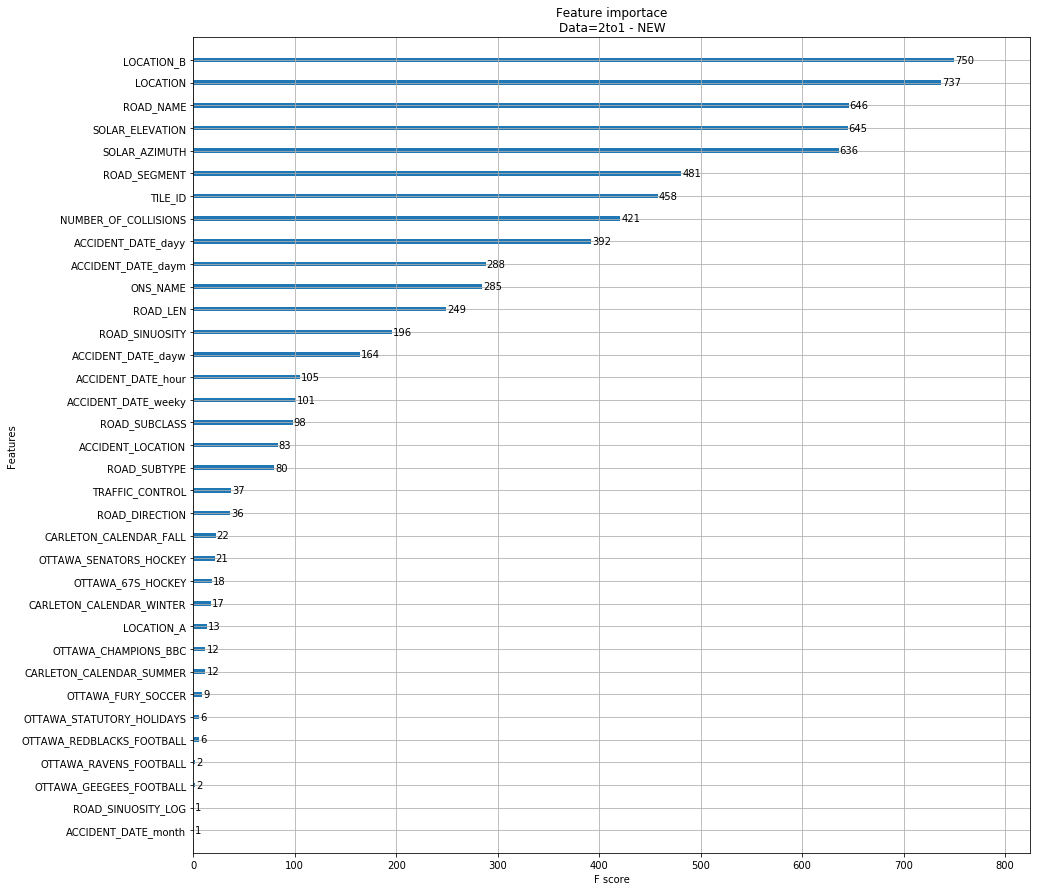

In [16]:
plt.figure(figsize=(15,15))
xgboost.plot_importance(booster,ax=plt.gca(),importance_type='weight', title = 'Feature importace\nData=' + data_type)

In [17]:
booster.save_model('0002.model')

# 7. Using the Model for Test Data (Prediction) and Evaluate the Performance

In [18]:
# Calculate the Predictions (Probabilities)
y_pred_train_prob = booster.predict(X_train)
y_pred_test_prob = booster.predict(X_test)

## 7.1 ROC Curve

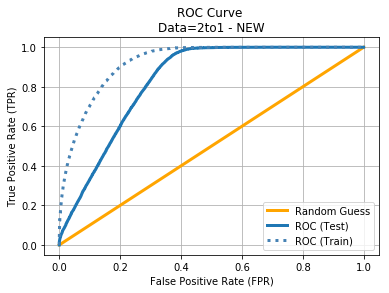

In [19]:
fpr, tpr, thresholds = roc_curve(y_test,y_pred_test_prob)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train,y_pred_train_prob)

fig,ax = plt.subplots()
plt.plot([0,1],[0,1],'r-',label='Random Guess',color='orange',lw=3)
plt.plot(fpr,tpr,label='ROC (Test)',lw=3)
plt.plot(fpr_train,tpr_train,'r:',label='ROC (Train)',color='steelblue',lw=3)
plt.title('ROC Curve \nData=' + data_type)
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.grid()
plt.legend()

## 7.2 TPR / FPR Curve

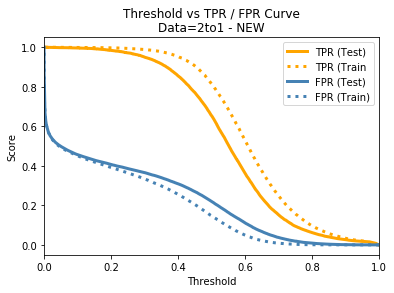

In [20]:
plt.plot(thresholds,tpr,'r-',label='TPR (Test)',color='orange',lw=3)
plt.plot(thresholds_train,tpr_train,'r:',label='TPR (Train',color='orange',lw=3)
plt.plot(thresholds,fpr,'r-',label='FPR (Test)',color='steelblue',lw=3)
plt.plot(thresholds_train,fpr_train,'r:',label='FPR (Train)',color='steelblue',lw=3)
plt.gca().set_xbound(lower=0,upper=1)
#plt.plot([0.5,0.5],[0,1],'k-',lw=2)
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title('Threshold vs TPR / FPR Curve\nData='+data_type)
plt.legend()

## 7.3 Precision/Recall (PR)

<Figure size 1080x1080 with 0 Axes>

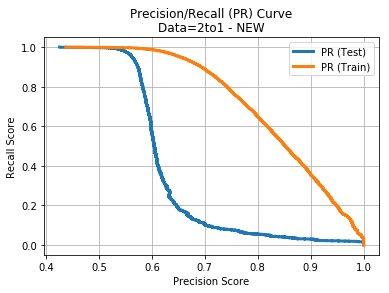

In [21]:
plt.figure(figsize=(15,15))
precision,recall,thresholds = precision_recall_curve(y_test,y_pred_test_prob)
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train,y_pred_train_prob)
fig,ax = plt.subplots()
plt.plot(precision,recall,label='PR (Test)',lw=3)
plt.plot(precision_train,recall_train,label='PR (Train)',lw=3)
plt.title('Precision/Recall (PR) Curve\nData='+data_type)
plt.xlabel("Precision Score")
plt.ylabel("Recall Score")
plt.grid()
plt.legend()

## 7.4 Threshold - Precision/Recall

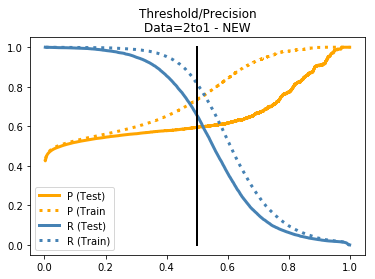

In [22]:
plt.plot(thresholds,precision[:-1],'r-',label='P (Test)',color='orange',lw=3)
plt.plot(thresholds_train,precision_train[:-1],'r:',label='P (Train',color='orange',lw=3)
plt.plot(thresholds,recall[:-1],'r-',label='R (Test)',color='steelblue',lw=3)
plt.plot(thresholds_train,recall_train[:-1],'r:',label='R (Train)',color='steelblue',lw=3)
plt.gca().set_xbound(lower=0,upper=1)
plt.plot([0.5,0.5],[0,1],'k-',lw=2)
plt.title('Threshold/Precision\nData='+data_type)
plt.legend()

## 7.5  Select the best threshold and Calculate Final Predicted Class

In [23]:
tresh = 0.5 # This value was selected using the previous graphs

# Calculate final class based on threshold
y_pred_train_class = np.copy(y_pred_train_prob)
y_pred_test_class = np.copy(y_pred_test_prob)

y_pred_train_class[y_pred_train_class < tresh] = 0
y_pred_train_class[y_pred_train_class >= tresh] = 1

y_pred_test_class[y_pred_test_class < tresh] = 0
y_pred_test_class[y_pred_test_class >= tresh] = 1

## 7.6 Model Accuracy Results

In [24]:
print('=============================================')
print('Data='+data_type+', threhold=' + str(tresh) )
print('=============================================')
print ('Test Accuracy:',accuracy_score(y_test,y_pred_test_class))
print ('Test F1:',f1_score(y_test,y_pred_test_class))
print ('Test Precision:',precision_score(y_test,y_pred_test_class))
print ('Test AP:',average_precision_score(y_test,y_pred_test_class))
print ('Test Recall:',recall_score(y_test,y_pred_test_class))
print ('Test AUC:',roc_auc_score(y_test,y_pred_test_prob))
print('=============================================')
print ('Train Accuracy:',accuracy_score(y_train,y_pred_train_class))
print ('Train F1:',f1_score(y_train,y_pred_train_class))
print ('Train Precision:',precision_score(y_train,y_pred_train_class))
print ('Test AP:',average_precision_score(y_train,y_pred_train_class))
print ('Train Recall:',recall_score(y_train,y_pred_train_class))
print ('Train AUC:',roc_auc_score(y_train,y_pred_train_prob))

Data=2to1 - NEW, threhold=0.5
Test Accuracy: 0.7382731958762887
Test F1: 0.6232330352836419
Test Precision: 0.5952515946137491
Test AP: 0.5038157011895487
Test Recall: 0.6539749279763295
Test AUC: 0.829214567395677
Train Accuracy: 0.8401228294967525
Train F1: 0.7732343172275491
Train Precision: 0.7352879830755937
Test AP: 0.6612340655073643
Train Recall: 0.8153104040704398
Train AUC: 0.9246643230841628


## 7.4.1  Confusion Matrix

In [25]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## 7.4.1.1 Training

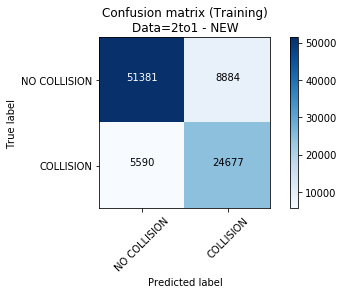


Classification report training data=2to1 - NEW, threshold=0.5
              precision    recall  f1-score   support

NO COLLISION       0.90      0.85      0.88     60265
   COLLISION       0.74      0.82      0.77     30267

   micro avg       0.84      0.84      0.84     90532
   macro avg       0.82      0.83      0.82     90532
weighted avg       0.85      0.84      0.84     90532



In [26]:
cm = confusion_matrix(y_train, y_pred_train_class)
plot_confusion_matrix(cm, ['NO COLLISION', 'COLLISION'], title ='Confusion matrix (Training)\nData='+data_type )
print("\nClassification report training data=" + data_type + ', threshold='+str(tresh))
print("===================================================================")
print(classification_report(y_train, y_pred_train_class,target_names=['NO COLLISION', 'COLLISION']))

## 7.4.1.2 Test

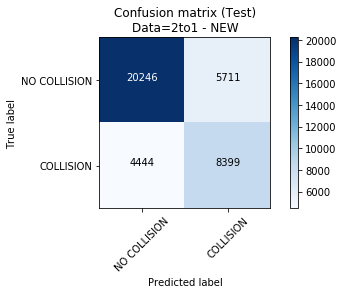


Classification report test data=2to1 - NEW, threshold=0.5
              precision    recall  f1-score   support

NO COLLISION       0.82      0.78      0.80     25957
   COLLISION       0.60      0.65      0.62     12843

   micro avg       0.74      0.74      0.74     38800
   macro avg       0.71      0.72      0.71     38800
weighted avg       0.75      0.74      0.74     38800



In [27]:
cm = confusion_matrix(y_test, y_pred_test_class)
plot_confusion_matrix(cm, ['NO COLLISION', 'COLLISION'], title ='Confusion matrix (Test)\nData='+data_type )
print("\nClassification report test data=" + data_type + ', threshold='+str(tresh))
print("===================================================================")
print(classification_report(y_test, y_pred_test_class,target_names=['NO COLLISION', 'COLLISION']))

## 7.5 Cross-validation (with all Dataset)

In [28]:
print(params)
early_stopping_rounds = 50
num_boost_round = 999

X_all = Xs
y_all = Y
fnames = np.array(feature_names)[feature_sel]

X_all = xgboost.DMatrix(X_all,label=y_all,feature_names=fnames)


cv_results = xgboost.cv(
        params,
        X_all,
        num_boost_round=num_boost_round,
        seed=2019,
        nfold=5,
        metrics=['auc','error'],
        verbose_eval=1,
        early_stopping_rounds=early_stopping_rounds
    )
cv_results

{'max_depth': 6, 'min_child_weight': 5.0, 'reg_lambda': 1.0, 'reg_alpha': 0.0, 'scale_pos_weight': 1.0, 'eval_metric': 'auc', 'objective': 'binary:logistic', 'subsample': 0.7, 'eta': 0.3, 'seed': 2019, 'silent': 1}
[0]	train-auc:0.67499+0.0111627	train-error:0.323344+0.00116675	test-auc:0.674163+0.010561	test-error:0.323671+0.0021438
[1]	train-auc:0.685336+0.00755593	train-error:0.321034+0.00154029	test-auc:0.682464+0.00728524	test-error:0.3219+0.00247404
[2]	train-auc:0.696979+0.0073139	train-error:0.320387+0.000858952	test-auc:0.694664+0.00606459	test-error:0.321243+0.00245809
[3]	train-auc:0.707902+0.01322	train-error:0.320238+0.00075297	test-auc:0.705496+0.0135008	test-error:0.320949+0.00264076
[4]	train-auc:0.720735+0.00657213	train-error:0.320108+0.000993391	test-auc:0.716158+0.00837313	test-error:0.321127+0.00275034
[5]	train-auc:0.721399+0.00688911	train-error:0.319809+0.00106893	test-auc:0.717091+0.00866734	test-error:0.320864+0.00246856
[6]	train-auc:0.725537+0.00818235	train

[64]	train-auc:0.869279+0.00110729	train-error:0.223152+0.00196484	test-auc:0.826198+0.00109396	test-error:0.266817+0.00131323
[65]	train-auc:0.870154+0.00133947	train-error:0.22191+0.00167505	test-auc:0.826676+0.00121419	test-error:0.266276+0.00167713
[66]	train-auc:0.871004+0.00136645	train-error:0.221075+0.00164897	test-auc:0.826979+0.000993887	test-error:0.265673+0.00180427
[67]	train-auc:0.871755+0.00144643	train-error:0.219851+0.00127613	test-auc:0.827263+0.000808811	test-error:0.265325+0.00167515
[68]	train-auc:0.872453+0.00132522	train-error:0.219375+0.00124049	test-auc:0.827378+0.00061097	test-error:0.265248+0.00163015
[69]	train-auc:0.873111+0.00152695	train-error:0.218708+0.00178969	test-auc:0.827322+0.000572385	test-error:0.265232+0.00152491
[70]	train-auc:0.873676+0.00150603	train-error:0.217891+0.00187097	test-auc:0.827413+0.000590794	test-error:0.265077+0.00143446
[71]	train-auc:0.874291+0.00151196	train-error:0.217384+0.00193865	test-auc:0.82749+0.000618125	test-error:0

[129]	train-auc:0.901263+0.00106633	train-error:0.187405+0.00138659	test-auc:0.828706+0.0021404	test-error:0.26316+0.00224363
[130]	train-auc:0.90156+0.00116997	train-error:0.187001+0.00157847	test-auc:0.828741+0.00217473	test-error:0.263245+0.00197781
[131]	train-auc:0.901953+0.00110093	train-error:0.186481+0.00166252	test-auc:0.828718+0.00222546	test-error:0.263098+0.00161929
[132]	train-auc:0.902294+0.00099384	train-error:0.186002+0.00138228	test-auc:0.828622+0.00214553	test-error:0.262975+0.00201562
[133]	train-auc:0.902552+0.000902086	train-error:0.185752+0.00119698	test-auc:0.828694+0.00219494	test-error:0.262905+0.00206425
[134]	train-auc:0.902884+0.000890901	train-error:0.185588+0.0013902	test-auc:0.828602+0.00228019	test-error:0.262913+0.00186182
[135]	train-auc:0.903244+0.000925792	train-error:0.18524+0.00148145	test-auc:0.82847+0.00215847	test-error:0.263307+0.0016804
[136]	train-auc:0.903609+0.000898697	train-error:0.184896+0.00146232	test-auc:0.828402+0.00208009	test-error

,train-auc-mean,train-auc-std,train-error-mean,train-error-std,test-auc-mean,test-auc-std,test-error-mean,test-error-std
0,0.674990,0.011163,0.323344,0.001167,0.674163,0.010561,0.323671,0.002144
1,0.685336,0.007556,0.321034,0.001540,0.682464,0.007285,0.321900,0.002474
2,0.696979,0.007314,0.320387,0.000859,0.694664,0.006065,0.321243,0.002458
3,0.707902,0.013220,0.320238,0.000753,0.705496,0.013501,0.320949,0.002641
4,0.720735,0.006572,0.320108,0.000993,0.716158,0.008373,0.321127,0.002750
5,0.721399,0.006889,0.319809,0.001069,0.717091,0.008667,0.320864,0.002469
6,0.725537,0.008182,0.319579,0.001100,0.720685,0.007989,0.320895,0.002569
7,0.737193,0.007049,0.318680,0.001179,0.732552,0.008147,0.320184,0.002348
8,0.750756,0.012234,0.317317,0.002321,0.746139,0.014981,0.318877,0.003428
9,0.755827,0.013848,0.315869,0.002648,0.750519,0.017412,0.317733,0.003620


In [29]:
print('Best number of trees = {}'.format(cv_results.shape[0]))
cv_results.iloc[cv_results.shape[0] - 1]

Best number of trees = 107


train-auc-mean      0.892394
train-auc-std       0.001356
train-error-mean    0.197457
train-error-std     0.001561
test-auc-mean       0.829431
test-auc-std        0.002024
test-error-mean     0.261405
test-error-std      0.002582
Name: 106, dtype: float64

# Save Dataset 

In [30]:
#df.to_csv("Ottawa Tabular Collision Data 2015-2017 FINAL ENCODED DATA with Sampling and Events '+data_type+".csv", 
#          index = None)